In [14]:
%matplotlib inline
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_style("white")
sns.set_context('paper')

import mne
from autoreject import LocalAutoRejectCV
mne.set_log_level('ERROR')

import pandas as pd
import scipy.stats as stats
from os import listdir
import numpy as np
from scipy.stats import ttest_rel as t_rel 
from collections import Counter

event_ids = {"con/hc":201, "con/lc":200, "inc/lc":210, "inc/hc":211}

loc_epochs = "/.../n4-p6/" # location of raw files
template = loc_epochs + "{}-epo.fif" # location of epoched data

savs="/.../" # location to save figures and csvs

In [15]:
bads = ["VLA21", # not a native speaker of German
        "GMA05","RAC22","PBT16","HHA01","BSN17"]

In [16]:
names = list({fname.split("-")[0]  # list of participant IDs
              for fname in listdir(loc_epochs) 
              if "epo" in fname and fname.split("-")[0] not in bads
             })

In [17]:
def get_epochs(name):
    '''
    loads the epoched data for participant (name)
    '''
    epoch = mne.read_epochs(template.format(name))
    return epoch

In [18]:
# get ERPs for conditions by subject
erps = dict()
for name in names:
    erps[name] = dict()
    epoch = get_epochs(name).drop_channels(["SO1", "SO2", "FP1", "FP2"])
    for cond in event_ids:
        erps[name][cond] = epoch[cond].average()

In [19]:
# average condition based ERPs for plotting difference wave
grands = {cond:mne.combine_evoked([erps[name][cond] for name in names], weights='equal')
          for cond in list(event_ids.keys())}

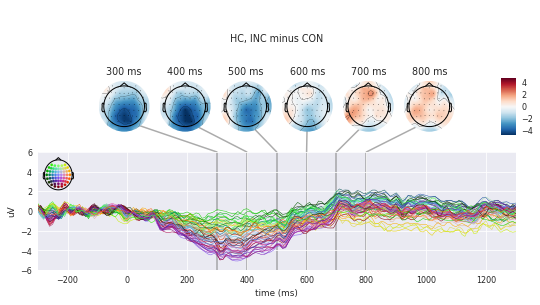

In [20]:
sns.set_context("paper")
sns.set_style("darkgrid")
# butterfly plot of incongruent-congruent trials
plt1 = mne.combine_evoked([grands["inc/hc"], grands["con/hc"],
                   ], weights=[1, -1]).plot_joint([.3, .4,0.5,.6, .7,.8], title="HC, INC minus CON", 
                                                  ts_args={"ylim":{"eeg":[-6, 6]}});

In [149]:
plt1.savefig(savs+'butters.pdf')

In [21]:
# average ERPs for for conditions (con/hc and inc/hc)
erp_hc = dict()
for cond in event_ids:
    if "hc" in cond:
        erp_hc[cond.split("/")[0]] = [erps[name][cond] for name in names]

erp = erps[name][cond]  # need this one for channel picking

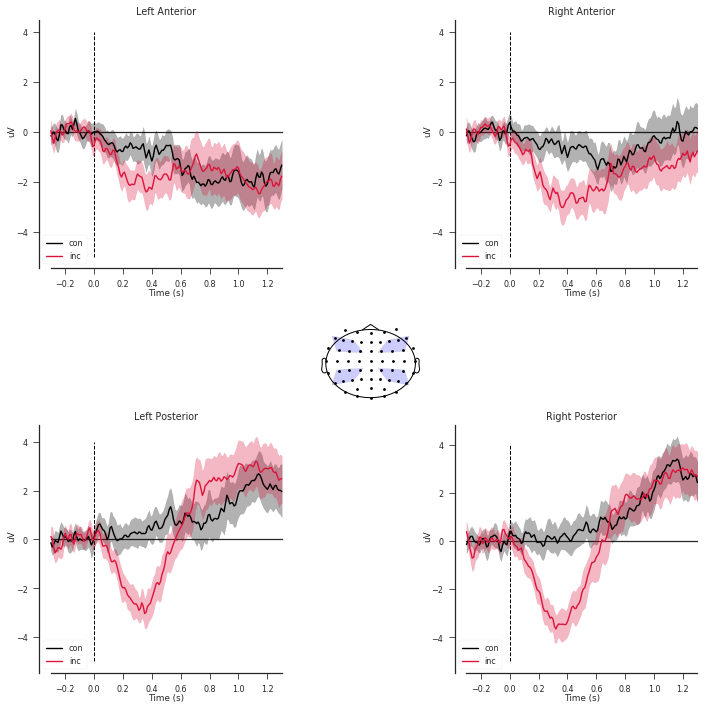

In [22]:
# plotting averaged activity over ROIs (Left anterior, right anterior, left posterior, right posterior)

from matplotlib import gridspec
from mne.datasets import testing
from mne.channels.layout import _find_topomap_coords
from scipy.spatial import ConvexHull
from matplotlib.patches import Polygon
from mne.viz.topomap import _draw_outlines, _check_outlines
from matplotlib.patches import ConnectionPatch

sns.set_style("ticks", {"xtick.major.size": 6, "ytick.major.size": 6})


f = plt.figure()
f.set_size_inches(12, 12)

gs = gridspec.GridSpec(5, 5)
ax1 = plt.subplot(gs[0:2, 0:2])
ax2 = plt.subplot(gs[0:2, 3:])
ax3 = plt.subplot(gs[3:5, :2])
ax4 = plt.subplot(gs[3:5,3:5])
ax_ = plt.subplot(gs[2, 2])

def plot_hull(points, ax):
    # outlines ROIs in sensor map
    hull = ConvexHull(points)
    cent = np.mean(points, 0)
    pts = []
    for pt in points[hull.simplices]:
        pts.append(pt[0].tolist())
        pts.append(pt[1].tolist())

    pts.sort(key=lambda p: np.arctan2(p[1] - cent[1],
                                    p[0] - cent[0]))
    pts = pts[0::2]  # Deleting duplicates
    pts.insert(len(pts), pts[0])
    k = 1.25
    color = 'blue'
    poly = Polygon(k*(np.array(pts)- cent) + cent,
                   edgecolor="k",
                   facecolor=color, alpha=0.2)
    poly.set_capstyle('round')
    ax.add_patch(poly)

evoked = erp_hc["con"][0]

pos_xy = np.asarray(_find_topomap_coords(evoked.info, range(len(evoked.ch_names)))) # get channel coordinates
pos_x, pos_y = pos_xy.T

# define rois
roi_names = {"Left Frontal":['F3', 'F5', 'FC3', 'F7', 'FC1', 'FC5'],
       "Right Frontal": ['F4', 'FC4', 'F6', 'F8', 'FC2', 'FC6'],
                         'Left Parietal': ['CP1', 'CP3', 'P5', 'CP5', 'P3', 'P7'],
                         'Right Parietal': ['CP2', 'P6', 'CP4', 'CP6', 'P4', 'P8']}
roi_picks = {k:[evoked.ch_names.index(ch) for ch in v] for k, v in roi_names.items()}

outlines = "skirt"
pos, outlines = _check_outlines(pos_xy, outlines)

_draw_outlines(ax_, outlines);
x_, y_ = pos.T
ax_.plot(x_, y_, 'k.')
ax_.axis("off")

for name, roi in roi_picks.items():
    pts = np.array(pos)[roi]
    plot_hull(pts, ax_)
    x, y = pts.mean(0)
    ax_.plot(x, y, 0, 1)

vmax = evoked.data.max() / .000001
vmin = evoked.data.min() / .000001

ax_dict = {"Left Frontal": ax1, "Right Frontal": ax2,
           "Left Parietal": ax3, "Right Parietal": ax4}
edge_dict = {"Left": .80, "Right": .20, "Frontal": -.25, "Parietal": 1.15}

roin = {"Left Frontal": "Left Anterior", "Right Frontal": 'Right Anterior',
           "Left Parietal": "Left Posterior", "Right Parietal": "Right Posterior"}

places = {"Left Frontal": "A", "Right Frontal": "B",
           "Left Parietal": "C", "Right Parietal": "D"}

for name, roi in roi_picks.items(): 
    # plots individual ERP plots for condition averaged in each ROI 
    # with bootstrapped 95% confidence intervals
    place = places[name]    
    ax2_ = ax_dict[name]
    rn = roin[name]
    mne.viz.plot_compare_evokeds(erp_hc, axes=ax2_,colors=["k", "crimson"], show=False, linestyles=["-", "--"], 
                                 truncate_yaxis=False,truncate_xaxis=False,
                                 show_sensors=False,picks=roi, ylim={"eeg":(-5, 4)}, title="{}".format(rn))
    ax2_.tick_params("Arial", labelsize=10)

In [23]:
f.savefig(savs+"ERPs.pdf")

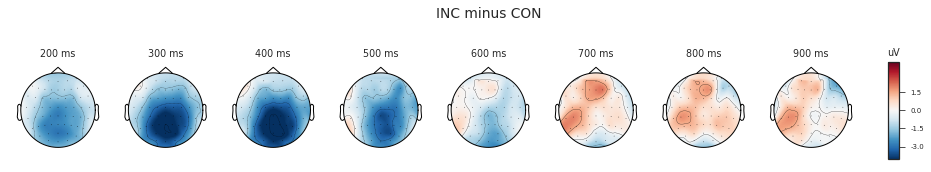

In [24]:
# plot topo maps
pl1 = mne.combine_evoked([grands["inc/hc"], grands["con/hc"],
                   ], weights=[1, -1]).plot_topomap(times=[0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
                                                    title="INC minus CON", vmin=-4, vmax=4);


In [220]:
pl1.savefig(savs+"topomaps.pdf")

In [156]:
def big_data(names):
    '''
    Creates a big data frame for all participants of epoched data by electrodes over time
    
        names: a list of names corresponding to participants
    '''
    
    # list of epochs looking only at HC
    #ep = {name: get_epochs(name)["hc"] for name in names}

    # create a massive dataframe for all channel and data for univariate analysis
    dfs = []
    ns = []
    for ii, name in enumerate(names):
        ep = get_epochs(name)["hc"]
        #df_ = ep[name].to_data_frame()
        df_ = ep.to_data_frame()
        df_ = df_.reset_index(level=1, drop=True)
        x = []
        #for k in ep[names[0]].event_id.keys():
        for k in ep.event_id.keys():
            d_t = df_.loc[k] 
            for i, m in d_t.iterrows():
                m["subj"] = ii
                m["cond"] = k.split("/")[0]
                m["times"] = i
                x.append(m)
        df_t = pd.DataFrame(x)
        df_ = pd.melt(df_t, id_vars=["subj","times","cond"],
                      var_name="electrode", value_name="uV") 

        dfs.append(df_)
        #ns.append(name)
    df2 = pd.concat(dfs)
    
    return df2

In [162]:
# save the dataframe as a csv to avoid having to do this over and over
# as it takes a long time to calculate
df2 = big_data(names)
df2.to_csv(savs+"big_data/big_data2.csv") 

In [98]:
df2 = pd.read_csv(savs+"big_data/big_data.csv") # to load the csv

In [163]:
def select_times(df, tmin, tmax):
    # average over time window of interest for all electrodes and subjects
    dft = df.query("{} < times < {}".format(tmin, tmax)).groupby(["subj", "cond",
                                                                      "electrode", 
                                                                      ]).mean().reset_index()
    return dft

def select_elecs(dataframe):
    # identify electrodes in ROIs
    
    ROIs = {'AL': ['F3', 'F5', 'FC3', 'F7', 'FC1', 'FC5'],
            'AR': ['F4', 'FC4', 'F6', 'F8', 'FC2', 'FC6'],
            'PL': ['CP1', 'CP3', 'P5', 'CP5', 'P3', 'P7'],
            'PR': ['CP2', 'P6', 'CP4', 'CP6', 'P4', 'P8']}
    
    dft = pd.DataFrame()
    for roi in ROIs:
        temp = dataframe[dataframe['electrode'].isin(ROIs[roi])].copy()
        r = []
        for ii, x in temp.iterrows():
            r.append(roi)
        temp["elecs"] = r 
        dft=dft.append(temp)
    return dft

def average_over_rois(df_):
    # average over region of interest
    # don't have to do this if electrodes are in the error term
    cs = ["con", "inc"]
    df = pd.DataFrame()
    rois, subj, condition, hemi, frontal, dep_v = [],[],[],[],[], []
    for ii, s in enumerate(Counter(df_.subj).keys()):
        d1 = df_.query("subj=={}".format(s))
        for roi in Counter(d1.elecs):
            x = d1.query("elecs=='{}'".format(roi))
            for c in cs:
                uV = x.query("cond=='{}'".format(c)).uV.mean()
                rois.append(roi), subj.append(s), condition.append(c) 
                hemi.append(list(x.hemi)[0]), frontal.append(list(x.frontal)[0]), dep_v.append(uV)
    df["subj"] = subj
    df["condition"] = condition
    df["elecs"] = rois
    df["hemi"] = hemi
    df["frontal"] = frontal
    df["uV"] = dep_v
    
    return df

def identify_position(df):  
    # average over rois and identify whether frontal/posterior and left/right
    df=pd.melt(select_elecs(df), id_vars=["subj", "cond", 
                                          "times", "elecs"], 
           value_vars="uV", value_name="uV").drop("variable", 1)
    
    hemi, anti = [], []
    for ii, m in df.iterrows():
        el = m.elecs
        a, h = el[0], el[1]
        anti.append(("frontal" if a=="A" else "posterior"))
        hemi.append(("left" if h=="L" else "right")) 
        
    df["hemi"] = hemi
    df["frontal"] = anti
    
    df = average_over_rois(df)
    return df


In [164]:
# define time windows of interest
n4_times =  [300, 500]
p6_times = [600, 800]

# create data frames for averaged ROIs and time windows for subjects
n4 = identify_position(select_times(df2, n4_times[0], n4_times[1])) # N400 time window
p6 = identify_position(select_times(df2, p6_times[0], p6_times[1])) # P600 time window

# save DataFrame for univariate statistics
n4.to_csv(savs+"n4-data.csv".format(str(n4_times[0]), str(n4_times[1])))
p6.to_csv(savs+"p6-data.csv".format(str(p6_times[0]), str(p6_times[1])))